### US ECO MODEL: US LEADING INDEX (US LEI)
- Model: Economic Time Series Signal adjusted for publication lag of the series
- Trading frequency: monthly
- Universe & Time Period:
	- S&P500 index: 1960 - Nov 2022
	- US Leading Economic Index (US LEI): 1960 - Nov 2022
- Simple rules:
	- If the economic impulse is positive, invest in the S&P500 as economic growth is strong.
	- If the economic impulse is negative, but recovering: invest in the S&P500 as economic 		growth is recovering.
	- If the economic impulse is negative and worsening: invest in US T-bills (Risk-off)
- Technical:
	- Economic impulse: the smoothed (3-month moving average) 6-month change in the LEI index.
	- Change in economic impulse (recovering, worsening): the one-month change in the impulse.
- **_Remarks_**:
	- The US Lei signal is adjusted to take into account the publication lag. The US LEI value 		for the previous month is published/known on the 22nd of each month.So there is around 1-		month lag. We adjust by shifting the series forward one month.
	- Trading costs: 50 bps 
	- Dividends are not taken into account.
	- Any mistakes remain mine. If you find any, please do let me know so I can rectify. Thank you!

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import yfinance as yf
import seaborn as sns
from statsmodels.formula.api import ols

In [30]:
#Import S&P500 daily data as a series
start='1950-01-01'
SP500_price=yf.download("^GSPC",start)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [31]:
#Calculate monthly S&P500 returns in (1+R) format
SP500_dly=(SP500_price.pct_change()+1).dropna()
SP500_mtly=SP500_dly.resample('M').prod()
SP500_mtly.index=SP500_mtly.index.tz_localize(None)

In [32]:
#Import Tbill data
Tbill_d=yf.download("^IRX",start)['Adj Close']
#Calculate monthly returns in (1+R) format
Tbill_dr=Tbill_d/100/252+1
Tbill_mtly=Tbill_dr.resample('M').prod()
Tbill_mtly.index=Tbill_mtly.index.tz_localize(None)

[*********************100%***********************]  1 of 1 completed


In [33]:
#Import the Lei index from CSV file
Lei=pd.read_csv('lei.csv',index_col=0)
Lei=Lei[26:]
#Change index type to dateime
Lei.index=pd.to_datetime(Lei.index)
Lei.index.names=['Date']
#Resample to end of month data just like S&P500, change column names
Lei=Lei.reset_index().resample('M',on='Date').first()

Lei.rename(columns={'Leading Economic Index': 'LEI'},inplace=True)
#Change datatype of col LEI to float
Lei['LEI']=Lei['LEI'].astype(float)

In [34]:
Lei.index

DatetimeIndex(['1959-01-31', '1959-02-28', '1959-03-31', '1959-04-30',
               '1959-05-31', '1959-06-30', '1959-07-31', '1959-08-31',
               '1959-09-30', '1959-10-31',
               ...
               '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30',
               '2022-10-31', '2022-11-30', '2022-12-31', '2023-01-31',
               '2023-02-28', '2023-03-31'],
              dtype='datetime64[ns]', name='Date', length=771, freq='M')

In [35]:
#Add SP500 & Tbill to Lei df
Lei['SP500_monthly']=SP500_mtly
Lei['Tbill_monthly']=Tbill_mtly
Lei

,LEI,SP500_monthly,Tbill_monthly
Date,,,
1959-01-31,25.2,1.004347,NaN
1959-02-28,25.6,0.999279,NaN
1959-03-31,25.9,1.000541,NaN
1959-04-30,26.0,1.038781,NaN
1959-05-31,26.3,1.018927,NaN
...,...,...,...
2022-11-30,113.5,1.053753,1.003431
2022-12-31,112.5,0.941029,1.003513
2023-01-31,111.5,1.061753,1.003583


In [36]:
#Shift the LEI index 1 month as the value quoted now per end of months is in reality only known like a month later. (22th publication date for LEI value previous month)
Lei['LEI']=Lei['LEI'].shift(1)
Lei

,LEI,SP500_monthly,Tbill_monthly
Date,,,
1959-01-31,NaN,1.004347,NaN
1959-02-28,25.2,0.999279,NaN
1959-03-31,25.6,1.000541,NaN
1959-04-30,25.9,1.038781,NaN
1959-05-31,26.0,1.018927,NaN
...,...,...,...
2022-11-30,114.7,1.053753,1.003431
2022-12-31,113.5,0.941029,1.003513
2023-01-31,112.5,1.061753,1.003583


In [37]:
#Define lookback periods for LEI-index and calculate the medium-term momentum and the short-term momentum
Lei_lookback1= 6
Lei_lookback2=1
#Calculate LEI1: x-month moving average of y-month % LEI
Lei['LEI_1']=(Lei['LEI'].pct_change()+1).rolling(Lei_lookback1).apply(np.prod)-1
Lei['LEI_1']=Lei['LEI_1'].rolling(3).mean()
#Calculate LEI2: z-month change in smoothed x-month 
Lei['LEI_2']=Lei['LEI_1']-Lei['LEI_1'].shift(Lei_lookback2)
Lei


,LEI,SP500_monthly,Tbill_monthly,LEI_1,LEI_2
Date,,,,,
1959-01-31,NaN,1.004347,NaN,NaN,NaN
1959-02-28,25.2,0.999279,NaN,NaN,NaN
1959-03-31,25.6,1.000541,NaN,NaN,NaN
1959-04-30,25.9,1.038781,NaN,NaN,NaN
1959-05-31,26.0,1.018927,NaN,NaN,NaN
...,...,...,...,...,...
2022-11-30,114.7,1.053753,1.003431,-0.029387,-0.005607
2022-12-31,113.5,0.941029,1.003513,-0.033452,-0.004065
2023-01-31,112.5,1.061753,1.003583,-0.036767,-0.003315


In [38]:
#function that calculates the rolling returns on S&P500
def get_rolling_ret(series,n):
    """Calculate a rolling cumulative return for a given time window.
    Args:
        df(DataFrame): DataFrame with monthly returns of stocks in (1+R) format.
        n(int): Time window to calculate the cumulative return.
    Returns:
        DataFrame: DataFrame with returns for a given time window in (1+R)-format for
        each month.
    """
    return series.rolling(n).apply(np.prod)

In [39]:
#Built the trading signal
# create a list of our conditions
conditions=[
    (Lei['LEI_1']>=0),
    (Lei['LEI_1']<0)&(Lei['LEI_2']>=0),
    (Lei['LEI_1']<0)&(Lei['LEI_2']<0)    
    
]


# create a list of the values we want to assign for each condition
values = [1,1,0]

# create a new column and use np.select to assign values to it using our lists as arguments
Lei['Signal']=np.select(conditions,values)
Lei


,LEI,SP500_monthly,Tbill_monthly,LEI_1,LEI_2,Signal
Date,,,,,,
1959-01-31,NaN,1.004347,NaN,NaN,NaN,0
1959-02-28,25.2,0.999279,NaN,NaN,NaN,0
1959-03-31,25.6,1.000541,NaN,NaN,NaN,0
1959-04-30,25.9,1.038781,NaN,NaN,NaN,0
1959-05-31,26.0,1.018927,NaN,NaN,NaN,0
...,...,...,...,...,...,...
2022-11-30,114.7,1.053753,1.003431,-0.029387,-0.005607,0
2022-12-31,113.5,0.941029,1.003513,-0.033452,-0.004065,0
2023-01-31,112.5,1.061753,1.003583,-0.036767,-0.003315,0


In [40]:
#drop some na values
Lei.dropna(inplace=True)
#calculate turnover
Lei['TURN']=np.where(Lei['Signal'].shift(1)!=Lei['Signal'],1,0)
TO=Lei['TURN'].mean()
#calculate monthly returns Strategy in (1+R) format 
Lei['STRAT_monthly']=np.where(Lei['Signal'].shift(1)==1,Lei['SP500_monthly'],Lei['Tbill_monthly'])
#Take into account a transaction cost
commission=0.995
Lei['STRAT_monthly_net']=np.where(Lei['Signal'].shift(2)!=Lei['Signal'].shift(1),Lei['STRAT_monthly']*commission,Lei['STRAT_monthly'])
#Build a wealth index of SP500 and strategy for performance comparison
Lei['SP500_index']=Lei['SP500_monthly'].cumprod()
Lei['STRAT_index']=Lei['STRAT_monthly_net'].cumprod()
#relative performance
Lei['RELATIVE']=Lei['STRAT_index']/Lei['SP500_index']
Lei

,LEI,SP500_monthly,Tbill_monthly,LEI_1,LEI_2,Signal,TURN,STRAT_monthly,STRAT_monthly_net,SP500_index,STRAT_index,RELATIVE
Date,,,,,,,,,,,,
1960-01-31,26.7,0.928536,1.003460,0.005099,-0.002647,1,1,1.003460,0.998442,0.928536,0.998442,1.075287
1960-02-29,26.7,1.009171,1.002993,0.005041,-0.000058,1,0,1.009171,1.004125,0.937051,1.002561,1.069911
1960-03-31,26.7,0.986101,1.003030,0.011364,0.006323,1,0,0.986101,0.986101,0.924027,0.988627,1.069911
1960-04-30,26.6,0.982472,1.002563,0.010101,-0.001263,1,0,0.982472,0.982472,0.907831,0.971298,1.069911
1960-05-31,26.7,1.026853,1.002744,0.011383,0.001282,1,0,1.026853,1.026853,0.932209,0.997380,1.069911
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,114.7,1.053753,1.003431,-0.029387,-0.005607,0,0,1.003431,1.003431,68.126735,176.840998,2.595765
2022-12-31,113.5,0.941029,1.003513,-0.033452,-0.004065,0,0,1.003513,1.003513,64.109201,177.462269,2.768125
2023-01-31,112.5,1.061753,1.003583,-0.036767,-0.003315,0,0,1.003583,1.003583,68.068127,178.098178,2.616469


In [41]:
Lei

,LEI,SP500_monthly,Tbill_monthly,LEI_1,LEI_2,Signal,TURN,STRAT_monthly,STRAT_monthly_net,SP500_index,STRAT_index,RELATIVE
Date,,,,,,,,,,,,
1960-01-31,26.7,0.928536,1.003460,0.005099,-0.002647,1,1,1.003460,0.998442,0.928536,0.998442,1.075287
1960-02-29,26.7,1.009171,1.002993,0.005041,-0.000058,1,0,1.009171,1.004125,0.937051,1.002561,1.069911
1960-03-31,26.7,0.986101,1.003030,0.011364,0.006323,1,0,0.986101,0.986101,0.924027,0.988627,1.069911
1960-04-30,26.6,0.982472,1.002563,0.010101,-0.001263,1,0,0.982472,0.982472,0.907831,0.971298,1.069911
1960-05-31,26.7,1.026853,1.002744,0.011383,0.001282,1,0,1.026853,1.026853,0.932209,0.997380,1.069911
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,114.7,1.053753,1.003431,-0.029387,-0.005607,0,0,1.003431,1.003431,68.126735,176.840998,2.595765
2022-12-31,113.5,0.941029,1.003513,-0.033452,-0.004065,0,0,1.003513,1.003513,64.109201,177.462269,2.768125
2023-01-31,112.5,1.061753,1.003583,-0.036767,-0.003315,0,0,1.003583,1.003583,68.068127,178.098178,2.616469


In [42]:
#save the strat return series to CSV
strat_return_series=Lei['STRAT_monthly_net']-1
strat_return_series.index.rename('date',inplace=True)
strat_return_series.name='lei_return'
strat_return_series.to_csv('lei_return.csv')

In [43]:
Lei.STRAT_index

date
1960-01-31      0.998442
1960-02-29      1.002561
1960-03-31      0.988627
1960-04-30      0.971298
1960-05-31      0.997380
                 ...    
2022-11-30    176.840998
2022-12-31    177.462269
2023-01-31    178.098178
2023-02-28    178.720663
2023-03-31    179.091034
Freq: M, Name: STRAT_index, Length: 759, dtype: float64

In [44]:
#Turnover
TA=(((1+TO)**12)-1)*100
#YearFrac
YearFraq=Lei.shape[0]/12
#Annualized Returns
Strat_ar=(Lei['STRAT_index'][-1])**(1/YearFraq)-1
Bench_ar=(Lei['SP500_index'][-1])**(1/YearFraq)-1
#AnnualizedVol
Strat_vol=Lei['STRAT_monthly'].std()*np.sqrt(12)
Bench_vol=Lei['SP500_monthly'].std()*np.sqrt(12)
#Sharpe
Strat_sharpe=Strat_ar/Strat_vol
Bench_sharpe=Bench_ar/Bench_vol
#Drawdowns Strategy
Strat_max=Lei['STRAT_index'].cummax()
Strat_dd=Lei['STRAT_index']/Strat_max-1
#Drawdowns Index
Bench_max=Lei['SP500_index'].cummax()
Bench_dd=Lei['SP500_index']/Bench_max-1
#MaxDrawdown
Strat_md=min(Strat_dd)
Bench_md=min(Bench_dd)
#Return/MaxDrawdown
Strat_r_to_md=Strat_ar/abs(Strat_md)
Bench_r_to_md=Bench_ar/abs(Bench_md)
#Put Everything in DataFrame
Output_dict={'Performance Metrics':['CAGR%','Volatility','CAGR/Vol','Max Drawdown %','CAGR/MaxDrawdown','Average Turnover per Year'],
        'Strategy':['{:.2f}%'.format(Strat_ar*100),'{:.2f}%'.format(Strat_vol*100),'{:.2f}'.format(Strat_sharpe),'{:.2f}%'.format(Strat_md*100),'{:.2f}'.format(Strat_r_to_md),'{:.2f}%'.format(TA)],
        'Benchmark':['{:.2f}%'.format(Bench_ar*100),'{:.2f}%'.format(Bench_vol*100),'{:.2f}'.format(Bench_sharpe),'{:.2f}%'.format(Bench_md*100),'{:.2f}'.format(Bench_r_to_md),'{:.2f}%'.format(0)]}

start=Lei.index[0].strftime("%Y-%m")
end = Lei.index[-1].strftime("%Y-%m")

Metrics=pd.DataFrame(Output_dict)
Metrics=Metrics.rename(columns={'Performance Metrics':'Performance Metrics '+'( '+start+' till '+end+ ')'})
Metrics

,Performance Metrics ( 1960-01 till 2023-03),Strategy,Benchmark
0,CAGR%,8.55%,6.83%
1,Volatility,12.52%,14.92%
2,CAGR/Vol,0.68,0.46
3,Max Drawdown %,-35.10%,-52.56%
4,CAGR/MaxDrawdown,0.24,0.13
5,Average Turnover per Year,115.02%,0.00%


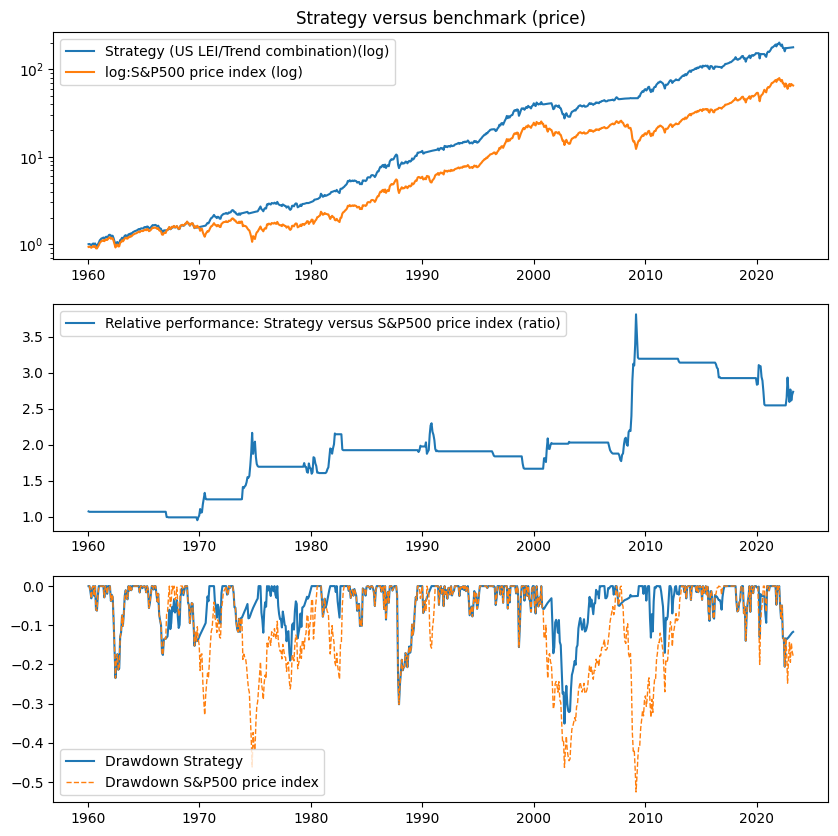

In [66]:
fig,ax=plt.subplots(3,1,figsize=(10,10))
ax[0].set_title("Strategy versus benchmark (price)")
ax[0].semilogy(Lei['STRAT_index'],label="Strategy (US LEI/Trend combination)(log)")
ax[0].semilogy(Lei['SP500_index'],label="log:S&P500 price index (log)")
ax[0].legend()
ax[1].plot(Lei['RELATIVE'],label="Relative performance: Strategy versus S&P500 price index (ratio)")
ax[1].legend()
ax[2].plot(Strat_dd,label='Drawdown Strategy')
ax[2].plot(Bench_dd,label='Drawdown S&P500 price index',linestyle='--',linewidth=1)
ax[2].legend()
plt.savefig('strategy.png')
plt.show()

In [46]:
Lei['Year']=Lei.index.year
Lei['Month']=Lei.index.month
Lei

,LEI,SP500_monthly,Tbill_monthly,LEI_1,LEI_2,Signal,TURN,STRAT_monthly,STRAT_monthly_net,SP500_index,STRAT_index,RELATIVE,Year,Month
date,,,,,,,,,,,,,,
1960-01-31,26.7,0.928536,1.003460,0.005099,-0.002647,1,1,1.003460,0.998442,0.928536,0.998442,1.075287,1960,1
1960-02-29,26.7,1.009171,1.002993,0.005041,-0.000058,1,0,1.009171,1.004125,0.937051,1.002561,1.069911,1960,2
1960-03-31,26.7,0.986101,1.003030,0.011364,0.006323,1,0,0.986101,0.986101,0.924027,0.988627,1.069911,1960,3
1960-04-30,26.6,0.982472,1.002563,0.010101,-0.001263,1,0,0.982472,0.982472,0.907831,0.971298,1.069911,1960,4
1960-05-31,26.7,1.026853,1.002744,0.011383,0.001282,1,0,1.026853,1.026853,0.932209,0.997380,1.069911,1960,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,114.7,1.053753,1.003431,-0.029387,-0.005607,0,0,1.003431,1.003431,68.126735,176.840998,2.595765,2022,11
2022-12-31,113.5,0.941029,1.003513,-0.033452,-0.004065,0,0,1.003513,1.003513,64.109201,177.462269,2.768125,2022,12
2023-01-31,112.5,1.061753,1.003583,-0.036767,-0.003315,0,0,1.003583,1.003583,68.068127,178.098178,2.616469,2023,1


In [47]:
#create a pivot table of the strategy with strategy returns as values, years as rows and columns as as month values
Strat_pivot = Lei.pivot(values='STRAT_monthly_net',index='Year',columns='Month')
#rename the columns labels with month names
months = ['Jan','Feb','March','April','May','June','July','Aug','Sep','Oct','Nov','Dec']
Strat_pivot.rename(columns=dict(enumerate(months,1)),inplace=True)
#Add a column that contains the total return for each year
Strat_pivot['Total']=Strat_pivot.prod(axis=1)
#get normal monhtly returns 
Strat_pivot=(Strat_pivot-1)*100

In [48]:
#create a function to style a dataframe that shows returns in pivot form
def style_df(df_):
    def style_negative(v, props=''):
        return props if v < 0 else None
    styles = [
        dict(selector="tr:hover",
                    props=[("background", "#D6EEEE")]),
        dict(selector="th", props=[("color", "#fff"),
                                   ("border", "0px solid #eee"),
                                   ("padding", "1px 10px"),
                                   ("border-collapse", "collapse"),
                                   ("background", "#2C3E50"),                             
                                   ("font-size", "12px")
                                   ]),
        dict(selector="td", props=[("border", "1px solid #EAECEE"),
                                   ("padding", "5px 10px"),
                                   ("border-collapse", "collapse"),
                                   ("font-size", "12px")
                                    ]),
        dict(selector="table", props=[                                   
                                        ("font-family" , 'sans-serif'),
                                        ("margin" , "25px auto"),
                                        ("border-collapse" , "collapse"),
                                        ("border" , "1px solid #eee"),
                                        ("border-bottom" , "2px solid #00cccc"),                                    
                                          ]),
        dict(selector="caption", props=[("caption-side", "bottom")]),
        dict(selector="tr:nth-child(even)", props=[
            ("background-color", "#fff"),
        ]),
    ]
    
    x= df_.style.applymap(style_negative, props='color:red;')\
    .format(formatter='{:,.2f}%'.format,na_rep='-').set_table_styles(styles)
  
   
                                                                             
    return x

In [49]:
style_df(Strat_pivot)

Month,Jan,Feb,March,April,May,June,July,Aug,Sep,Oct,Nov,Dec,Total
Year,,,,,,,,,,,,,
1960,-0.16%,0.41%,-1.39%,-1.75%,2.69%,1.95%,-2.48%,2.61%,-6.04%,-0.24%,4.03%,4.63%,3.81%
1961,6.32%,2.69%,2.55%,0.38%,1.91%,-2.88%,3.28%,1.96%,-1.97%,2.83%,3.93%,0.32%,23.13%
1962,-3.79%,1.63%,-0.59%,-6.20%,-8.60%,-8.18%,6.36%,1.53%,-4.82%,0.44%,10.16%,1.35%,-11.81%
1963,4.91%,-2.89%,3.55%,4.85%,1.43%,-2.02%,-0.35%,4.87%,-1.10%,3.22%,-1.05%,2.44%,18.89%
1964,2.69%,0.99%,1.52%,0.61%,1.15%,1.64%,1.82%,-1.62%,2.87%,0.81%,-0.52%,0.39%,12.97%
1965,3.32%,-0.15%,-1.45%,3.42%,-0.77%,-4.86%,1.34%,2.25%,3.20%,2.73%,-0.88%,0.90%,9.06%
1966,0.49%,-1.79%,-2.18%,2.05%,-5.41%,-1.61%,-1.35%,-7.78%,-0.70%,4.75%,0.31%,-0.09%,-13.04%
1967,0.39%,0.33%,3.42%,4.22%,-5.24%,1.75%,4.53%,-1.17%,3.28%,-3.53%,0.75%,2.63%,11.41%
1968,-4.38%,-3.12%,0.94%,8.05%,1.25%,0.91%,-1.85%,1.15%,3.85%,0.72%,4.80%,-4.16%,7.66%


<AxesSubplot: xlabel='Year'>

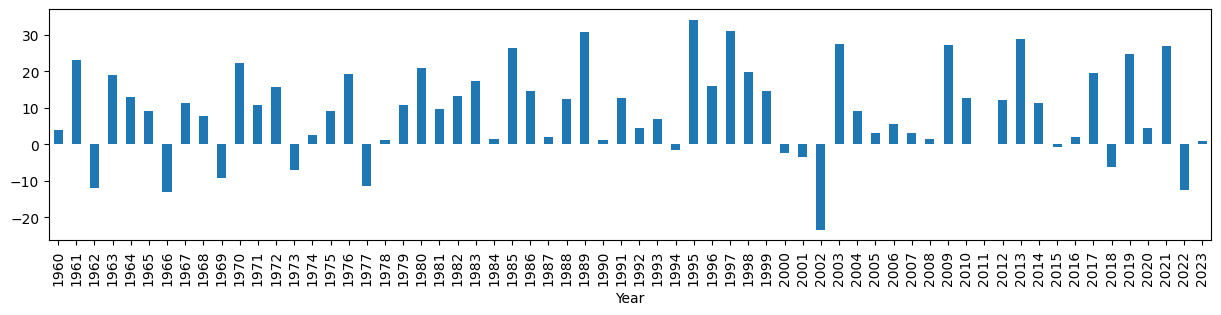

In [50]:
fig2,ax=plt.subplots(figsize=(15,3))
Strat_pivot['Total'].plot(kind='bar')

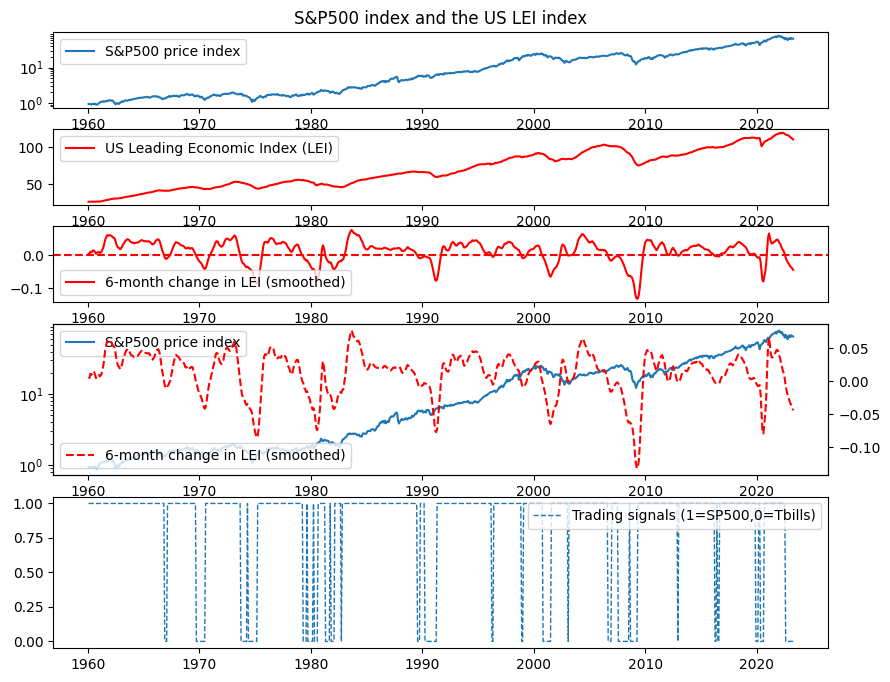

In [51]:
fig3,ax=plt.subplots(5,1,figsize=(10,8),gridspec_kw={'height_ratios': [1, 1,1,2,2]})
ax[0].set_title("S&P500 index and the US LEI index")
ax[0].semilogy(Lei['SP500_index'],label='S&P500 price index')
ax[0].legend()
ax[1].plot(Lei['LEI'],label='US Leading Economic Index (LEI)',color='red')
ax[1].legend()
ax[2].plot(Lei['LEI_1'],label='6-month change in LEI (smoothed)',color='red')
ax[2].axhline(y=0,color='red',linestyle='--')
ax[2].legend()
ax[3].semilogy(Lei['SP500_index'],label='S&P500 price index')
ax2=ax[3].twinx()
ax2.plot(Lei['LEI_1'],label='6-month change in LEI (smoothed)',color='red',linestyle='--')
ax[3].legend()
ax2.legend()
ax[4].plot(Lei['Signal'],label='Trading signals (1=SP500,0=Tbills)',linewidth=1,linestyle='--')
ax[4].legend()

In [52]:
#save figures
fig.savefig('strategy.png')
fig3.savefig('us_lei.png')

In [53]:
x=Lei.loc['2022-07','SP500_index'][0]
y=Lei.loc['2021-12','SP500_index'][0]
z=x/y-1
z
#market already down 13% in end of July 2022 and 20% drawdown midst of June. then came the signal. So strategy is in Tbills currently as of August 2022.


-0.13341714187599218

<AxesSubplot: xlabel='date'>

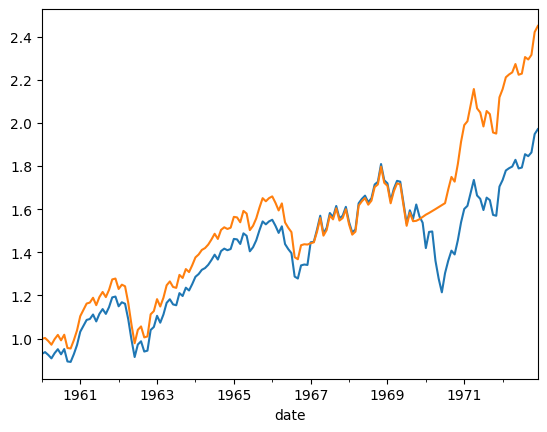

In [54]:
#The sixties
Lei['1960':'1972']['SP500_index'].plot()
Lei['1960':'1972']['STRAT_index'].plot()

<AxesSubplot: xlabel='date'>

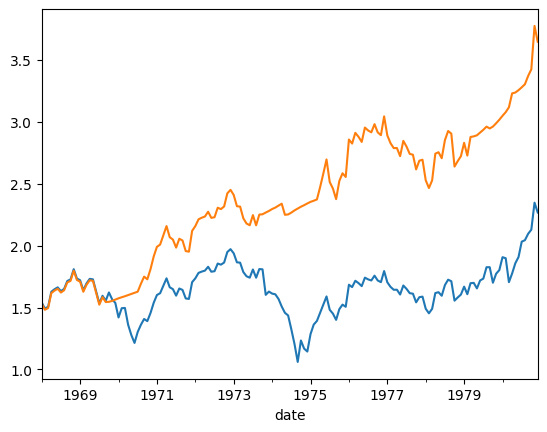

In [55]:
#The seventies
Lei['1968':'1980']['SP500_index'].plot()
Lei['1968':'1980']['STRAT_index'].plot()

<AxesSubplot: xlabel='date'>

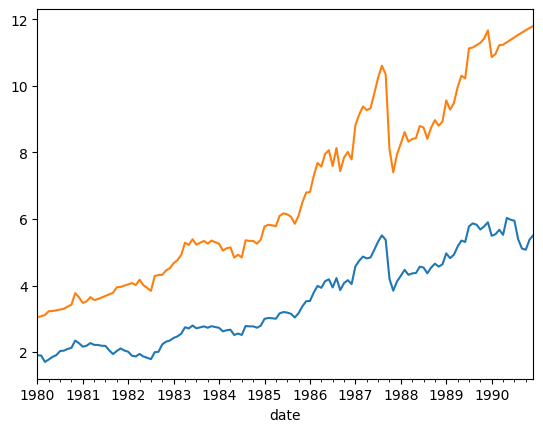

In [56]:
#The eighties
Lei['1980':'1990']['SP500_index'].plot()
Lei['1980':'1990']['STRAT_index'].plot()

<AxesSubplot: xlabel='date'>

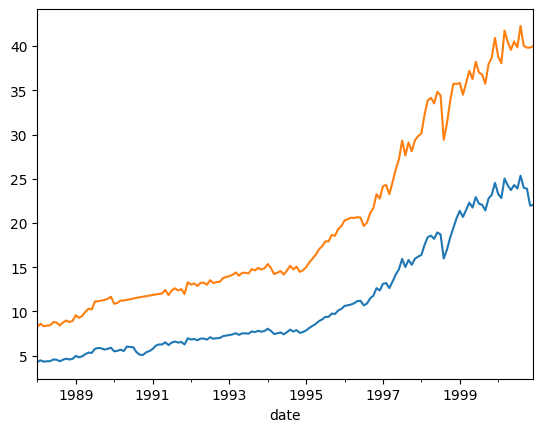

In [57]:
#The nineties
Lei['1988':'2000']['SP500_index'].plot()
Lei['1988':'2000']['STRAT_index'].plot()

<AxesSubplot: xlabel='date'>

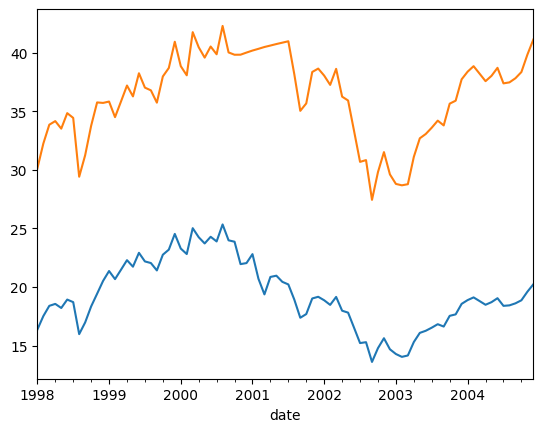

In [58]:
#1998-2004
Lei['1998':'2004']['SP500_index'].plot()
Lei['1998':'2004']['STRAT_index'].plot()

<AxesSubplot: xlabel='date'>

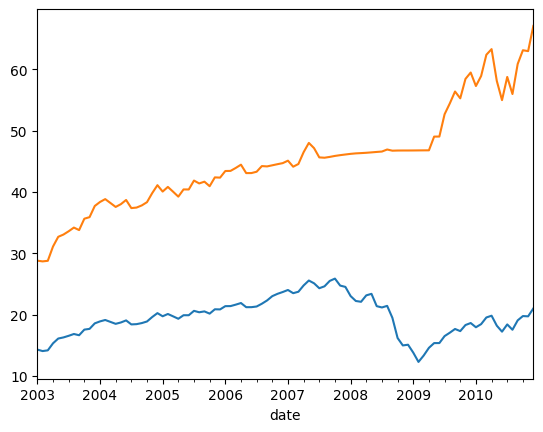

In [59]:
#2007/2008 crash
Lei['2003':'2010']['SP500_index'].plot()
Lei['2003':'2010']['STRAT_index'].plot()

<AxesSubplot: xlabel='date'>

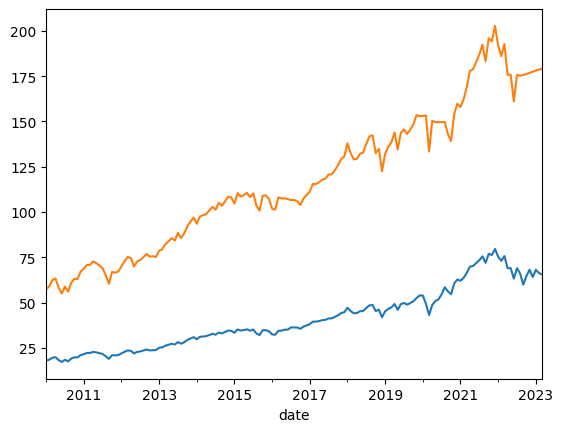

In [60]:
#Last
Lei['2010':]['SP500_index'].plot()
Lei['2010':]['STRAT_index'].plot()

In [61]:
Lei.SP500_monthly

date
1960-01-31    0.928536
1960-02-29    1.009171
1960-03-31    0.986101
1960-04-30    0.982472
1960-05-31    1.026853
                ...   
2022-11-30    1.053753
2022-12-31    0.941029
2023-01-31    1.061753
2023-02-28    0.973888
2023-03-31    0.987189
Freq: M, Name: SP500_monthly, Length: 759, dtype: float64

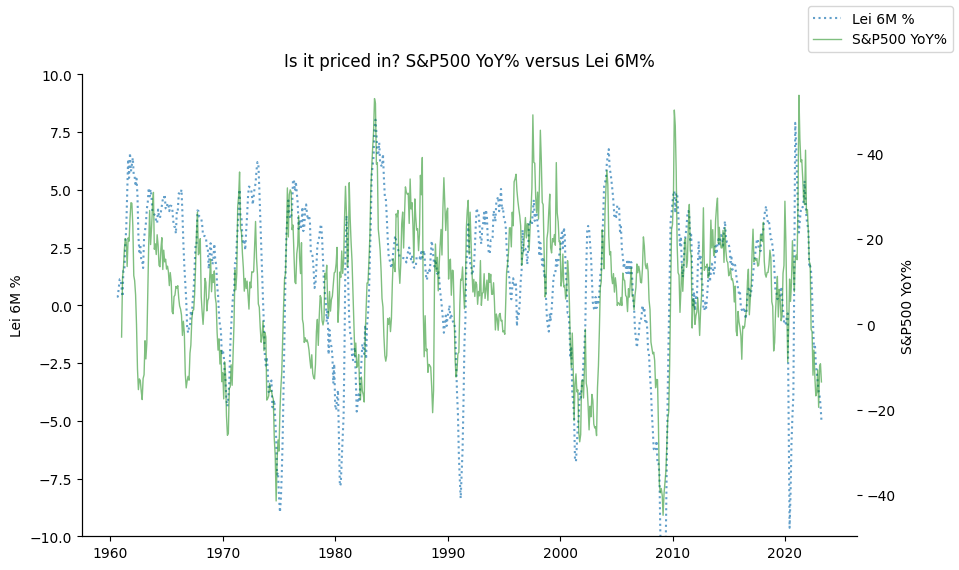

In [62]:
#is it priced in
df={}

df['sp500_yoy']=((Lei['SP500_monthly']).rolling(12).apply(np.prod)-1)*100
df['lei_6m']=((Lei['LEI'].pct_change()+1).rolling(6).apply(np.prod)-1)*100

df=pd.DataFrame(df)

fig,ax = plt.subplots(figsize=(10,6))
plt.title('Is it priced in? S&P500 YoY% versus Lei 6M%')

ax.plot(df.lei_6m,label='Lei 6M %',alpha=0.7,linestyle=':')
ax.set_ylabel('Lei 6M %')
ax.set_ylim(-10,10)

ax2=ax.twinx()
ax2.plot(df.sp500_yoy,label='S&P500 YoY%',linewidth=1,color='g',alpha=0.5)
ax2.set_ylabel('S&P500 YoY%')


fig.legend()
sns.despine()
plt.show()

In [63]:
returns=yf.download('^GSPC',start='2000-01-31')['Adj Close'].pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


The latest S&P500 YoY is -13.0% and the latest Lei 6m% is -4.98%
model parameters:
Intercept    5.180544
lei_6m       2.571611
dtype: float64
S&P500 YoY should trade at -7.63% according to ols-model


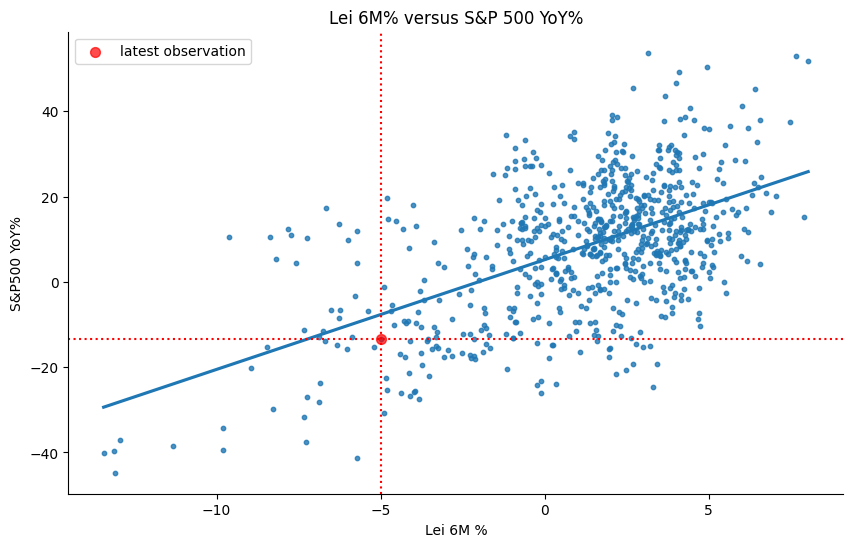

In [64]:
#IS IT PRICED IN

#latest known values for LEI_6M % and sp500 YoY%
sp500_latest=((returns+1).resample('M').prod().rolling(12).apply(np.prod)-1)[-1]
lei_latest=df.lei_6m[-1]
print(f'The latest S&P500 YoY is {round(sp500_latest,2)*100}% and the latest Lei 6m% is {round(lei_latest,2)}%')




#run the regression model
model=ols('sp500_yoy ~ lei_6m',data=df).fit()
print('model parameters:')
print(model.params)

#Predict for latest known regressor value
regressor=pd.DataFrame({'lei_6m':[lei_latest]})
prediction=model.predict(regressor)

print(f'S&P500 YoY should trade at {round(prediction[0],2)}% according to ols-model')


from statsmodels.formula.api import ols


fig,ax=plt.subplots(figsize=(10,6))
ax.set_title('Lei 6M% versus S&P 500 YoY%')


sns.regplot(x='lei_6m',y='sp500_yoy',data=df,ci=None,scatter_kws={'s':10})
ax.scatter(df.lei_6m[-1],sp500_latest*100,color='r',label='latest observation',s=50,alpha=0.7)
plt.axhline(sp500_latest*100,linestyle=':',color='r')
plt.axvline(df.lei_6m[-1],linestyle=':',color='r')

ax.set_xlabel('Lei 6M %')
ax.set_ylabel('S&P500 YoY%')
ax.legend()



sns.despine()
plt.show()